In [ ]:
!pip install scikit-learn yfinance


[*********************100%***********************]  1 of 1 completed


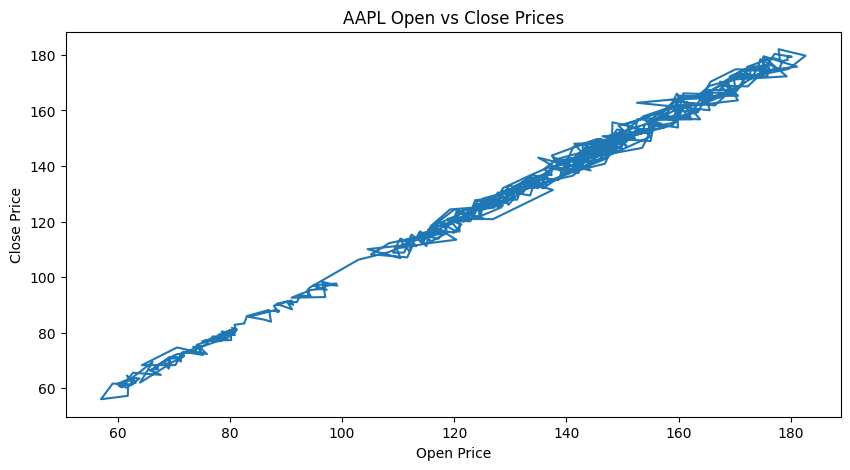

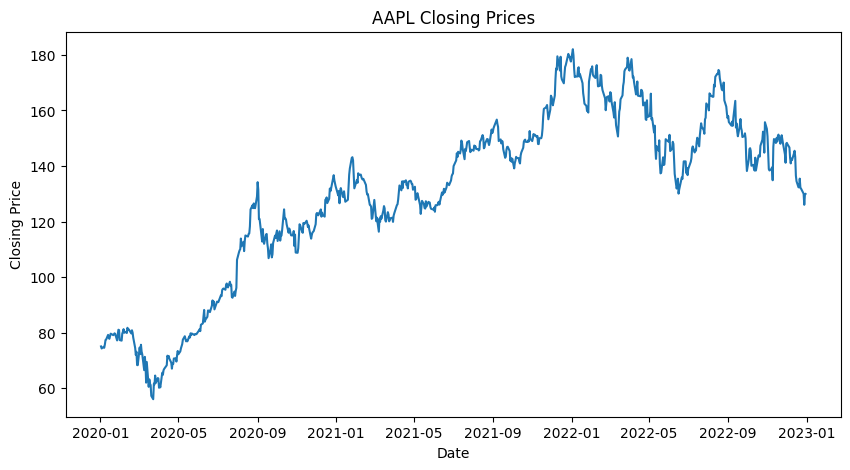

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilation time: 0.04128265380859375
Epoch 1/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4589 - val_loss: 0.0715
Epoch 2/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0606 - val_loss: 0.0597
Epoch 3/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0535 - val_loss: 0.0516
Epoch 4/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0424 - val_loss: 0.0194
Epoch 5/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0112 - val_loss: 6.7145e-04
Epoch 6/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.1753e-04 - val_loss: 3.1027e-04
Epoch 7/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6021e-04 - val_loss: 3.2778e-04
Epoch 8/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7107e-04 - val_loss: 4.3784e-04
Epoch 9/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.8421e-04 - val_loss: 6.7429e-04
Epoch 10/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9351e-04 - val_loss: 0.0010
Epoch 1/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4

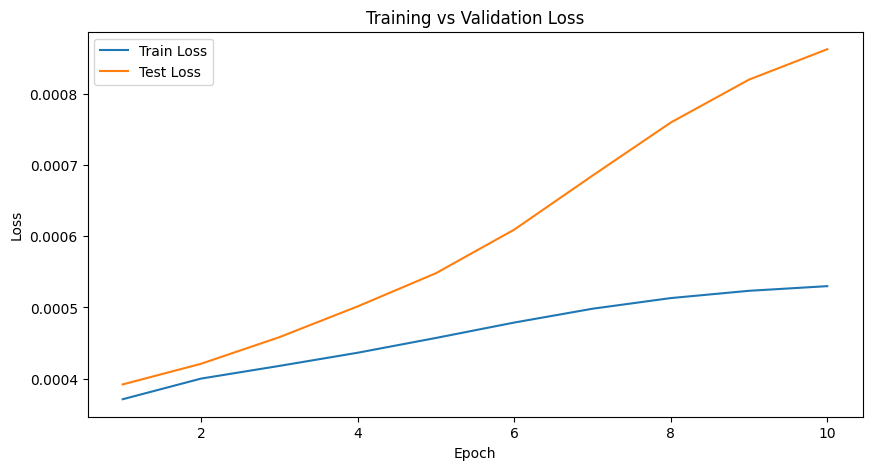

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Close Price for Open Price 150: 153.75421142578125


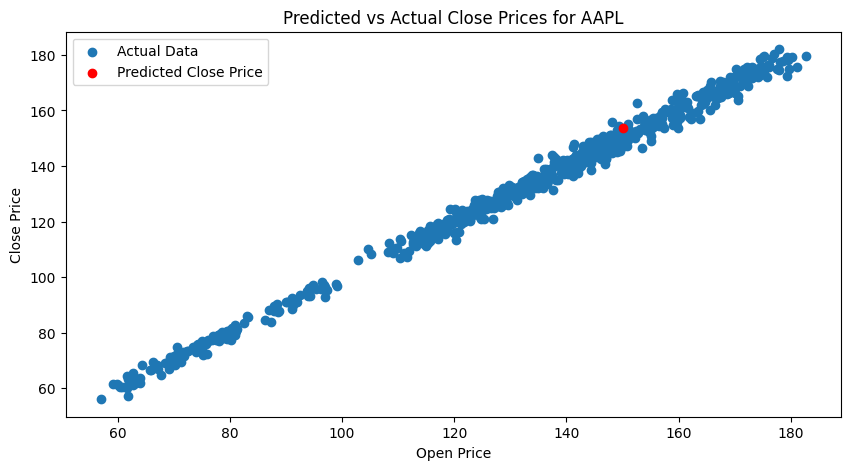

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time

# Set seeds for reproducibility
np.random.seed(0)
tf.compat.v1.set_random_seed(0)

# Download stock data using yfinance
ticker = 'AAPL'  # Apple stock as an example
stock_data = yf.download(ticker, start="2020-01-01", end="2023-01-01")

# Preprocessing the data
stock_data.dropna(inplace=True)  # Remove any rows with missing values

# Plot the Open vs Close prices
plt.figure(figsize=(10, 5))
plt.plot(stock_data['Open'].values, stock_data['Close'].values)
plt.title(f'{ticker} Open vs Close Prices')
plt.xlabel('Open Price')
plt.ylabel('Close Price')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(stock_data['Close'])
plt.title(f'{ticker} Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

# Scaling the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(stock_data['Open'].values.reshape(-1, 1))
Y = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

# KFold cross-validation with 2 splits
skf = KFold(n_splits=2, shuffle=True)
skf.get_n_splits(X, Y)

# Step 2: Build the Model
model = Sequential()

model.add(Dense(units=1, input_dim=1))
model.add(Activation('linear'))
model.add(Dense(units=1))
model.add(Activation('linear'))

# Compile the model
start = time.time()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.01))
print('Compilation time:', time.time() - start)

# Training the model with cross-validation
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Reshape data
    X_train = np.array(X_train).reshape(-1, 1)
    X_test = np.array(X_test).reshape(-1, 1)
    Y_train = np.array(Y_train).reshape(-1, 1)
    Y_test = np.array(Y_test).reshape(-1, 1)

    # Train the model
    hist = model.fit(
        X_train,
        Y_train,
        batch_size=1,
        epochs=10,
        validation_data=(X_test, Y_test)
    )

# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), hist.history['loss'], label="Train Loss")
plt.plot(range(1, 11), hist.history['val_loss'], label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

# Predict a sample price
sample_price = 150  # Example price (Open Price)
scaled_price = scaler.transform(np.array([sample_price]).reshape(-1, 1))
scaled_price = scaled_price.reshape(1, 1)
scaled_price = np.expand_dims(scaled_price, 0)

# Get the predicted price
predicted_price = scaler.inverse_transform(model.predict(scaled_price)).reshape(-1, 1)
print(f"Predicted Close Price for Open Price {sample_price}: {predicted_price[0][0]}")

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.scatter(stock_data['Open'], stock_data['Close'], label='Actual Data')
plt.scatter(sample_price, predicted_price, color="red", label="Predicted Close Price")
plt.xlabel("Open Price")
plt.ylabel("Close Price")
plt.legend()
plt.title(f"Predicted vs Actual Close Prices for {ticker}")
plt.show()
